# Feature extraction

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.io import loadmat
import wfdb
from wfdb import processing
from scipy.signal import peak_widths
import os

In [2]:
def segment_peaks(nsub, nseg, start=0, end=5000):

    # ECG segment
    ecg_mat = loadmat(f"ECG_segments_data/ecg_segments/ecg_sub{nsub}_seg{nseg}.mat")
    ecg = pd.DataFrame({
        't': ecg_mat['t'].squeeze(),
        'signal': ecg_mat['ecg'].squeeze()
    })
    ecg = ecg.reset_index()
    ecg.rename(columns={'index': 'idt'}, inplace=True)
    
    # Annotations
    peaks = pd.read_csv(f'ECG_segments_data/manual_annotations/ecg_sub{nsub}_seg{nseg}_labels.csv', header=None)
    peaks = peaks.reset_index()
    peaks.rename(columns={'index':'id_label', 0: 'idt', 1: 'label_desc', 2: 'label'}, inplace=True)
    
    # BayeSlope
    bayeslope_mat = loadmat(f'ECG_segments_data/Rpeaks_BayeSlope_Pulp/Rpeaks_BayeSlope_sub{nsub}_seg{nseg}.mat')
    bayeslope_array = bayeslope_mat['R_bs_cut']-1 # there is an error in the indexing
    bayeslope = pd.DataFrame(bayeslope_array)
    bayeslope = bayeslope.reset_index()
    bayeslope.rename(columns={'index':'id_BayeSlope', 0: 'idt'}, inplace=True)
    bayeslope['BayeSlope']='R'

    # Error class labels
    if (nsub, nseg)==(7, 5):
        labels = ['No-Error']*len(bayeslope_array)
        labels[17] = 'Noise'
        missed = ['--']*peaks.shape[0]
    elif os.path.exists(f'ECG_segments_data/error_class_mannual/labels_error_type_bs_sub{nsub}_seg{nseg}.mat') and os.path.exists(f'ECG_segments_data/error_class_mannual/labels_missed_manann_sub{nsub}_seg{nseg}.mat'):
        error_labels = loadmat(f'ECG_segments_data/error_class_mannual/labels_error_type_bs_sub{nsub}_seg{nseg}.mat')
        labels = error_labels['labels_error_type_bs'].squeeze()
        labels = [x[0] for x in labels]
        error_missed = loadmat(f'ECG_segments_data/error_class_mannual/labels_missed_manann_sub{nsub}_seg{nseg}.mat')
        missed = error_missed['labels_missed_manann'].squeeze()
        missed = [x[0] for x in missed]
    elif os.path.exists(f'ECG_segments_data/error_class_mannual/labels_error_type_bs_sub{nsub}_seg{nseg}.mat'):
        error_labels = loadmat(f'ECG_segments_data/error_class_mannual/labels_error_type_bs_sub{nsub}_seg{nseg}.mat')
        labels = error_labels['labels_error_type_bs'].squeeze()
        labels = [x[0] for x in labels]
        missed = ['--']*peaks.shape[0]
    elif os.path.exists(f'ECG_segments_data/error_class_mannual/labels_missed_manann_sub{nsub}_seg{nseg}.mat'):
        error_missed = loadmat(f'ECG_segments_data/error_class_mannual/labels_missed_manann_sub{nsub}_seg{nseg}.mat')
        missed = error_missed['labels_missed_manann'].squeeze()
        missed = [x[0] for x in missed]
        labels = ['No-Error']*len(bayeslope_array)
    else:
        labels = ['No-Error']*len(bayeslope_array)
        missed = ['--']*peaks.shape[0]
    bayeslope['error_class_label'] = labels
    peaks['error_missed_label'] = missed
    
    # Merges
    ECG = ecg.merge(bayeslope, how='left', on='idt')\
        .merge(peaks[['id_label', 'idt', 'label', 'error_missed_label']], how='left', on='idt')
    return ECG[(ECG['idt']>=start) & (ECG['idt']<=end)]

In [3]:
def comparitor_segment(nsub, nseg):

    # ECG
    ECG = segment_peaks(nsub, nseg)
    peaks_annotations = ECG[ECG['label']=='R']
    peaks_bayeslope = ECG[ECG['BayeSlope']=='R']

    # Comparitor
    ref_sample = peaks_annotations['idt'].to_numpy()
    test_sample = peaks_bayeslope['idt'].to_numpy()
    fs = 250
    t_tol = 0.050 # 50ms
    window_width = int(t_tol*fs)
    signal = ECG['signal'].to_numpy()
    
    return ECG, processing.compare_annotations(ref_sample, test_sample, window_width, signal)

In [4]:
def segment_features(nsub, nseg):
    ### Segment ###
    ecg, comparitor = comparitor_segment(nsub, nseg)
    
    Peaks = ecg[ecg['BayeSlope']=='R'][['idt', 't', 'signal', 'id_BayeSlope', 'error_class_label']].copy()
    
    ### minimum signal around the peak ###
    Peaks.sort_values(by='idt', ascending=True, inplace=True) # just in case, the order is important
    signals = ecg['signal'].to_numpy()
    Peaks['left_min_idt'] = np.nan
    Peaks['right_min_idt'] = np.nan
    
    for i, idt in Peaks['idt'].items():
        left = max(idt - 15, 0)
        Peaks.at[i, 'left_min_idt'] = left + np.argmin(signals[left:idt+1])
        right = min(idt + 15, 4999)
        Peaks.at[i, 'right_min_idt'] = idt + np.argmin(signals[idt:right+1])
    
    ### Amplitude and Width ###
    Peaks = Peaks.merge(ecg[['idt', 'signal']], how='left', left_on='left_min_idt', right_on='idt', suffixes=('', '_'))
    Peaks.rename(columns={'signal_': 'left_min_signal'}, inplace=True)
    Peaks = Peaks.merge(ecg[['idt', 'signal']], how='left', left_on='right_min_idt', right_on='idt', suffixes=('', '_'))
    Peaks.rename(columns={'signal_': 'right_min_signal'}, inplace=True)
    Peaks.drop(['idt_'], axis=1, inplace=True)
    
    Peaks['Amplitude'] = Peaks['signal'] - Peaks[['left_min_signal', 'right_min_signal']].min(axis=1)
    Peaks['Width'] = Peaks['right_min_idt'] - Peaks['left_min_idt']
    
    ### Consecutive errors ###
    Peaks['Error_ind'] = 0
    Peaks.loc[Peaks['id_BayeSlope'].isin(comparitor.unmatched_test_inds), 'Error_ind'] = 1
    Peaks.sort_values(by='idt', ascending=True, inplace=True) # just in case, the order is important
    consecutive_errors = []
    consecutive = 0
    for index, row in Peaks.iterrows():
        if row['Error_ind']==1:
            consecutive += 1
        else:
            consecutive=0
        consecutive_errors.append(consecutive)
    Peaks['consecutive_errors'] = consecutive_errors
    
    ### Previous and next peak features ###
    Peaks.sort_values(by='idt', ascending=True, inplace=True) # just in case, the order is important
    
    # RR intervals
    peaks2 = np.array(Peaks['idt'])
    RR = list(peaks2[1:] - peaks2[:-1])
    Peaks['RR_pre'] = [np.nan]+RR
    Peaks['RR_post'] = RR+[np.nan]
    
    # Amplitudes
    amplitudes = np.array(Peaks['Amplitude'])
    Peaks['A_pre'] = [np.nan] + list(amplitudes[:-1])
    Peaks['A_post'] = list(amplitudes[1:]) + [np.nan]
    
    # Widths
    widths = np.array(Peaks['Width'])
    Peaks['W_pre'] = [np.nan] + list(widths[:-1])
    Peaks['W_post'] = list(widths[1:]) + [np.nan]
    
    # Error isolation
    errors = np.array(Peaks['Error_ind'])
    Peaks['error_pre'] = [np.nan] + list(errors[:-1])
    Peaks['error_post'] = list(errors[1:]) + [np.nan]
    
    ### Error dataset ###
    Errors = Peaks[Peaks['Error_ind']==1].copy()
    
    # Error isolation
    Errors['Isolated'] = (Errors['error_pre'] + Errors['error_post']).apply(lambda x: 0 if x >= 1 else 1)
    
    # Ratios
    Errors['RR_ratio'] = Errors['RR_post']/Errors['RR_pre']
    Errors['A_pre_ratio'] = Errors['Amplitude']/Errors['A_pre']
    Errors['A_post_ratio'] = Errors['Amplitude']/Errors['A_post']
    Errors['W_pre_ratio'] = Errors['Width']/Errors['W_pre']
    Errors['W_post_ratio'] = Errors['Width']/Errors['W_post']

    ### Finish ###
    Errors.reset_index(drop=True, inplace=True)
    Errors.reset_index(drop=False, inplace=True)
    Errors.rename(columns={'index': 'id_error'}, inplace=True)
    Errors['id_subject'] = nsub
    Errors['id_segment'] = nseg
    
    # format
    Errors['id_BayeSlope'] = Errors['id_BayeSlope'].astype('int64')
    Errors['Width'] = Errors['Width'].astype('int64')
    Errors['consecutive_errors'] = Errors['consecutive_errors'].astype('int64')

    
    # order
    Errors = Errors[[
        'id_subject', 'id_segment', 'id_error', 'idt', 't', 'id_BayeSlope',
        'signal', 'Amplitude', 'A_pre', 'A_pre_ratio', 'A_post', 'A_post_ratio',
        'Width', 'W_pre', 'W_pre_ratio', 'W_post', 'W_post_ratio',
        'RR_pre', 'RR_post', 'RR_ratio', 'consecutive_errors', 'Isolated',
        'error_class_label'
    ]]
    
    return Errors

In [5]:
errors_list = [(2, 1), (2, 3), (2, 4), (2, 5), (4, 4), (4, 5), (6, 3), (7, 1), (7, 2), (7, 3),
               (7, 4), (7, 5), (13, 2), (13, 4), (15, 4), (21, 4), (22, 2)]

first=True
for nsub, nseg in errors_list:
    segment_data = segment_features(nsub, nseg)
    if first==True:
        Errors = segment_data
        first = False
    else:
        Errors = pd.concat([Errors, segment_data], ignore_index=True)

Errors.shape

(139, 23)

In [6]:
# There are 3 errors that in reality they are not errors, they are peaks so close to the end or the beginning of the ECG that there was no enough information to annotate a peak, so we will not take into account those errors
print(Errors[(Errors['id_subject']==13) & (Errors['id_segment']==2)])
print(Errors[(Errors['id_subject']==13) & (Errors['id_segment']==4)])
print(Errors[(Errors['id_subject']==15) & (Errors['id_segment']==4)])
Errors = Errors[Errors['error_class_label']!='No-Error']
Errors.shape

     id_subject  id_segment  id_error   idt            t  id_BayeSlope  \
131          13           2         0  1837  1018.378493            19   
132          13           2         1  4998  1031.022524            55   

     signal  Amplitude  A_pre  A_pre_ratio  ...  W_pre  W_pre_ratio  W_post  \
131     465        451  600.0     0.751667  ...   15.0     2.000000    13.0   
132     262        313  260.0     1.203846  ...   23.0     0.347826     NaN   

     W_post_ratio  RR_pre  RR_post  RR_ratio  consecutive_errors  Isolated  \
131      2.307692   211.0    134.0  0.635071                   1         1   
132           NaN    87.0      NaN       NaN                   1         1   

     error_class_label  
131              Noise  
132           No-Error  

[2 rows x 23 columns]
     id_subject  id_segment  id_error  idt           t  id_BayeSlope  signal  \
133          13           4         0    1  1446.01154             0      76   

     Amplitude  A_pre  A_pre_ratio  ...  W_pr

(136, 23)

In [7]:
Errors.head()

,id_subject,id_segment,id_error,idt,t,id_BayeSlope,signal,Amplitude,A_pre,A_pre_ratio,...,W_pre,W_pre_ratio,W_post,W_post_ratio,RR_pre,RR_post,RR_ratio,consecutive_errors,Isolated,error_class_label
0,2,1,0,1630,934.850406,19,153,131,124.0,1.056452,...,15.0,2.000000,16.0,1.875000,118.0,127.0,1.076271,1,1,T-wave
1,2,1,1,1822,935.618408,21,64,74,141.0,0.524823,...,16.0,0.875000,28.0,0.500000,65.0,59.0,0.907692,1,0,Noise
2,2,1,2,1881,935.854409,22,68,49,74.0,0.662162,...,14.0,2.000000,27.0,1.037037,59.0,82.0,1.389831,2,0,T-wave
3,2,1,3,1963,936.182410,23,93,80,49.0,1.632653,...,28.0,0.964286,20.0,1.350000,82.0,80.0,0.975610,3,0,T-wave
4,2,1,4,2043,936.502411,24,93,98,80.0,1.225000,...,27.0,0.740741,24.0,0.833333,80.0,122.0,1.525000,4,0,T-wave


In [8]:
Errors.to_csv("Supervised_learning/Error_features.csv", index=False)

# Data processing

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [10]:
errors_all = pd.read_csv("Supervised_learning/Error_features.csv")
errors_all.describe()

,id_subject,id_segment,id_error,idt,t,id_BayeSlope,signal,Amplitude,A_pre,A_pre_ratio,...,Width,W_pre,W_pre_ratio,W_post,W_post_ratio,RR_pre,RR_post,RR_ratio,consecutive_errors,Isolated
count,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,134.000000,134.000000,...,136.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,132.000000,136.000000,136.000000
mean,3.507353,3.404412,16.470588,2717.625000,1323.454284,32.970588,151.367647,179.779412,170.828358,1.887548,...,25.411765,23.738806,1.193110,23.970149,1.181217,91.186567,94.014925,1.118180,12.911765,0.132353
std,3.777117,0.953579,15.448333,1283.289205,158.384624,17.720857,140.730728,217.285192,241.339543,3.412570,...,6.079072,6.798860,0.574444,6.804400,0.563353,62.377479,54.573119,0.532071,13.700755,0.340127
min,2.000000,1.000000,0.000000,43.000000,919.118425,0.000000,-97.000000,26.000000,26.000000,0.045740,...,7.000000,7.000000,0.321429,7.000000,0.259259,56.000000,49.000000,0.458515,1.000000,0.000000
25%,2.000000,3.000000,3.000000,1801.750000,1323.493471,19.000000,85.750000,86.000000,82.250000,0.666066,...,23.000000,18.000000,0.926587,18.000000,0.925066,71.000000,72.000000,0.916373,2.000000,0.000000
50%,2.000000,4.000000,11.500000,2655.500000,1333.361432,32.500000,135.000000,120.000000,119.000000,1.046574,...,28.000000,27.000000,1.000000,27.000000,1.000000,75.000000,76.000000,0.984435,6.500000,0.000000
75%,2.000000,4.000000,28.250000,3816.750000,1367.260519,48.250000,172.500000,169.500000,160.000000,1.778366,...,30.000000,30.000000,1.258152,30.000000,1.237500,80.000000,86.750000,1.075038,21.250000,0.000000
max,22.000000,5.000000,53.000000,4947.000000,1940.203581,64.000000,1399.000000,1352.000000,2148.000000,29.058824,...,30.000000,30.000000,3.857143,30.000000,3.111111,654.000000,461.000000,4.153153,49.000000,1.000000


### Missing values

In [11]:
# remove rows with missing values
print(errors_all.shape)
errors = errors_all.dropna().reset_index(drop=True)
print(errors.shape)
print("% of rows with NaN: ", f'{(errors_all.shape[0]-errors.shape[0])/errors_all.shape[0]}%')

(136, 23)
(132, 23)
% of rows with NaN:  0.029411764705882353%


### Scaling

In the case of supervised learning, we need to split the data in training and testing sets, so scaling has to be made only based on the training set.

In [12]:
# ratios
errors['A_pre_ratio_log'] = np.log(errors['A_pre_ratio'].tolist())
errors['A_post_ratio_log'] = np.log(errors['A_post_ratio'].tolist())
errors['W_pre_ratio_log'] = np.log(errors['W_pre_ratio'].tolist())
errors['W_post_ratio_log'] = np.log(errors['W_post_ratio'].tolist())
errors['RR_ratio_log'] = np.log(errors['RR_ratio'].tolist())

In [13]:
errors.describe()

,id_subject,id_segment,id_error,idt,t,id_BayeSlope,signal,Amplitude,A_pre,A_pre_ratio,...,RR_pre,RR_post,RR_ratio,consecutive_errors,Isolated,A_pre_ratio_log,A_post_ratio_log,W_pre_ratio_log,W_post_ratio_log,RR_ratio_log
count,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,...,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000
mean,3.515152,3.401515,16.287879,2724.227273,1323.126946,33.000000,152.310606,181.871212,171.265152,1.904624,...,91.469697,94.469697,1.118180,12.840909,0.106061,0.067012,0.055181,0.077159,0.062616,0.041409
std,3.815366,0.963928,15.111560,1230.392376,160.644155,17.097386,142.667506,220.192019,243.121961,3.435444,...,62.808498,54.829707,0.532071,13.463453,0.309088,0.999040,0.830587,0.447913,0.446277,0.342185
min,2.000000,1.000000,0.000000,122.000000,919.118425,1.000000,-97.000000,26.000000,26.000000,0.045740,...,56.000000,57.000000,0.458515,1.000000,0.000000,-3.084784,-2.516655,-1.134980,-1.349927,-0.779762
25%,2.000000,3.000000,3.000000,1821.500000,1323.493471,19.000000,84.750000,86.000000,81.500000,0.673874,...,71.000000,72.000000,0.916373,2.000000,0.000000,-0.394763,-0.359910,-0.082742,-0.080043,-0.087332
50%,2.000000,4.000000,11.500000,2655.500000,1333.059431,32.500000,135.000000,120.000000,119.000000,1.046574,...,75.000000,76.000000,0.984435,6.500000,0.000000,0.045478,0.048990,0.000000,0.000000,-0.015689
75%,2.000000,4.000000,28.000000,3768.250000,1367.260519,48.000000,174.250000,171.000000,156.000000,1.830642,...,80.500000,87.500000,1.075038,21.250000,0.000000,0.604023,0.442813,0.261701,0.182322,0.072356
max,22.000000,5.000000,52.000000,4876.000000,1940.203581,63.000000,1399.000000,1352.000000,2148.000000,29.058824,...,654.000000,461.000000,4.153153,48.000000,1.000000,3.369322,3.084784,1.349927,1.134980,1.423868


### Outliers

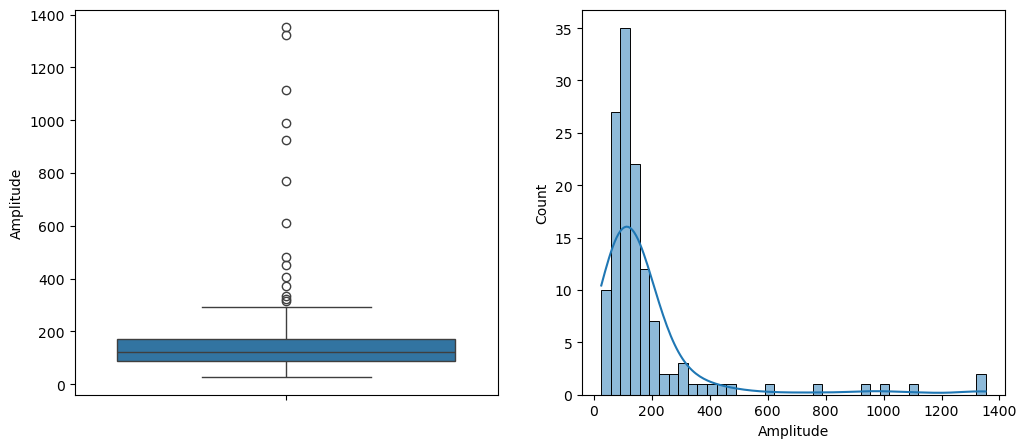

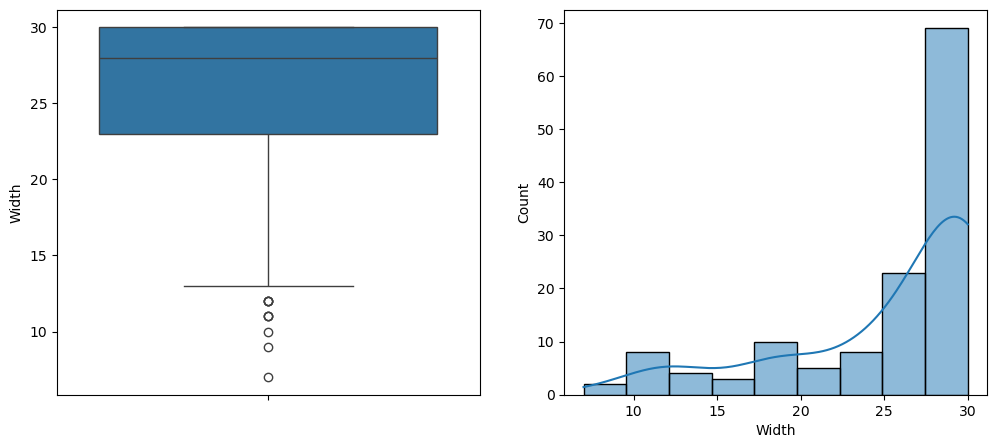

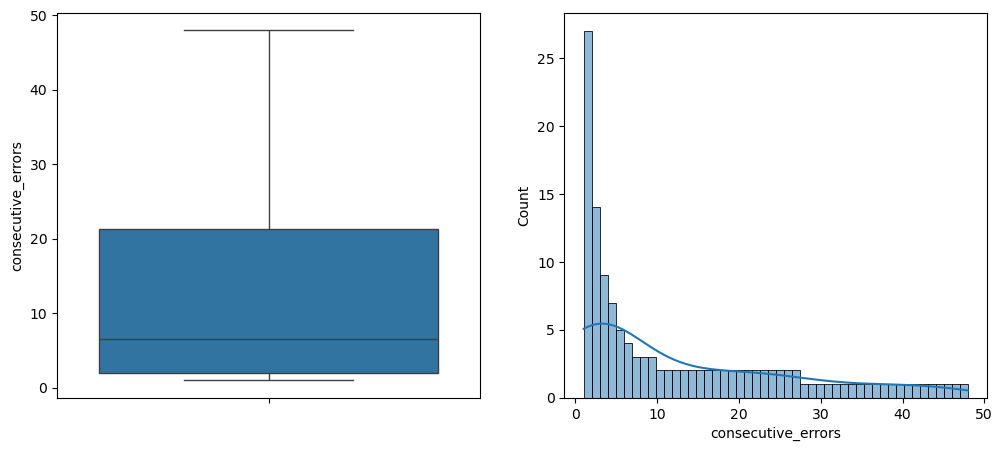

In [14]:
f, a = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(errors['Amplitude'], ax=a[0])
sns.histplot(errors['Amplitude'], ax=a[1], kde=True)
plt.show()

f, a = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(errors['Width'], ax=a[0])
sns.histplot(errors['Width'], ax=a[1], kde=True)
plt.show()

f, a = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(errors['consecutive_errors'], ax=a[0])
sns.histplot(errors['consecutive_errors'], ax=a[1], kde=True, bins=48)
plt.show()

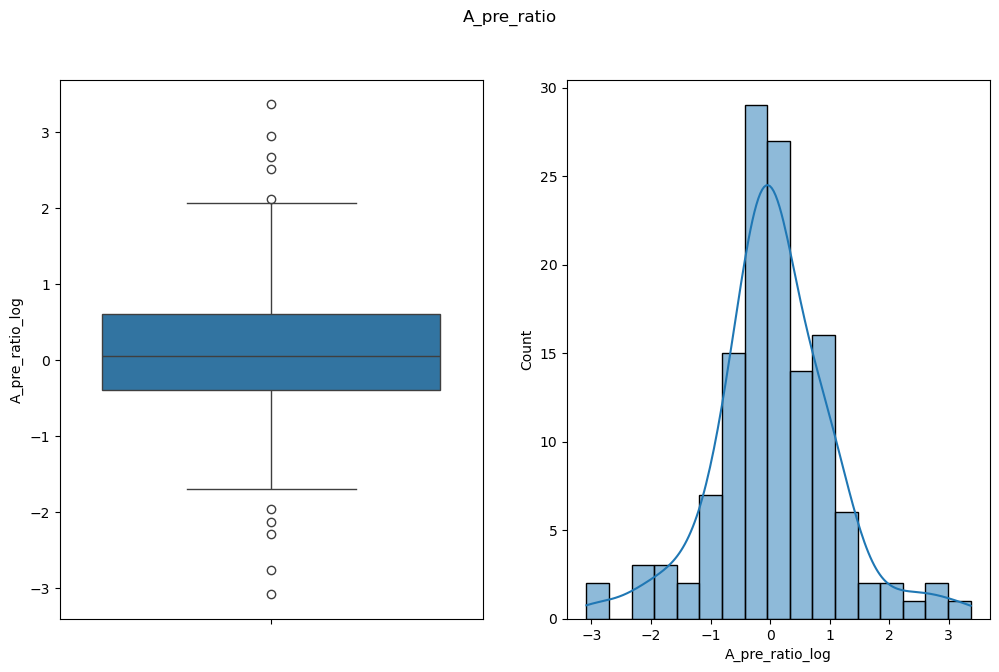

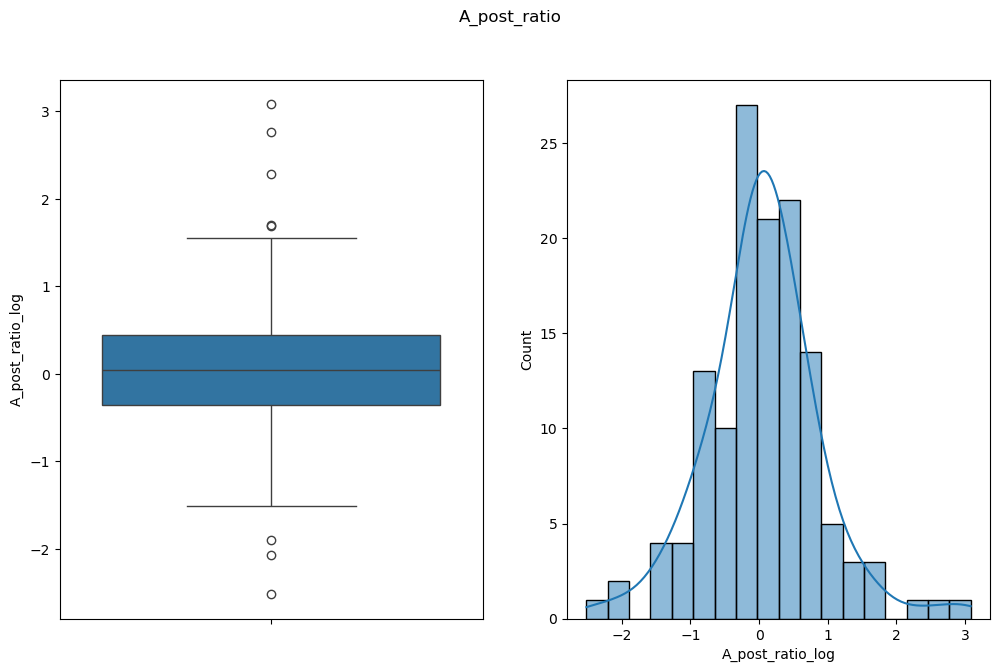

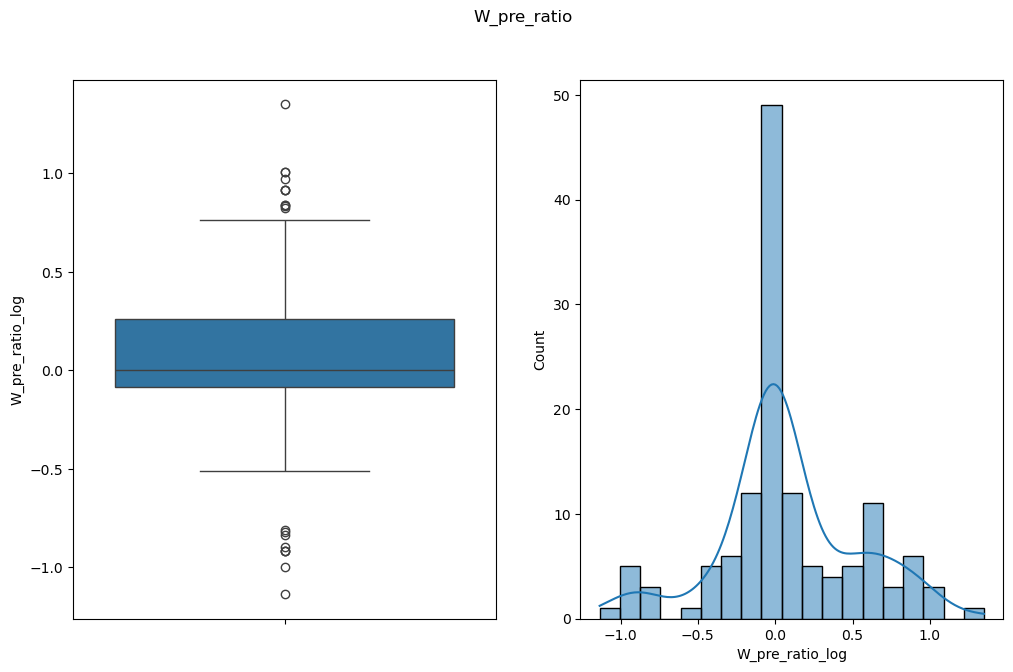

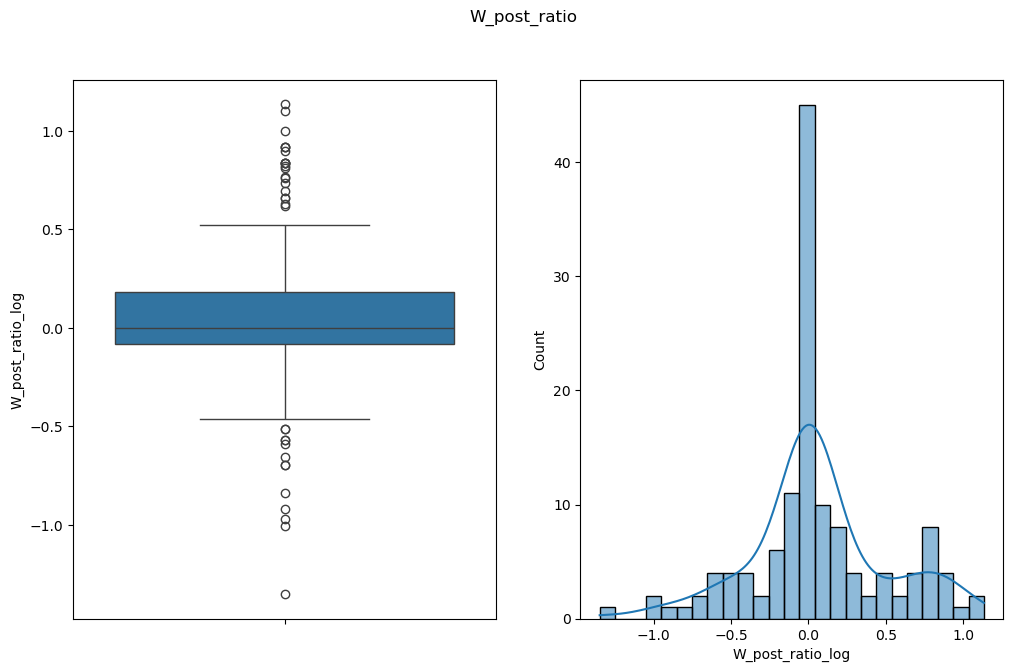

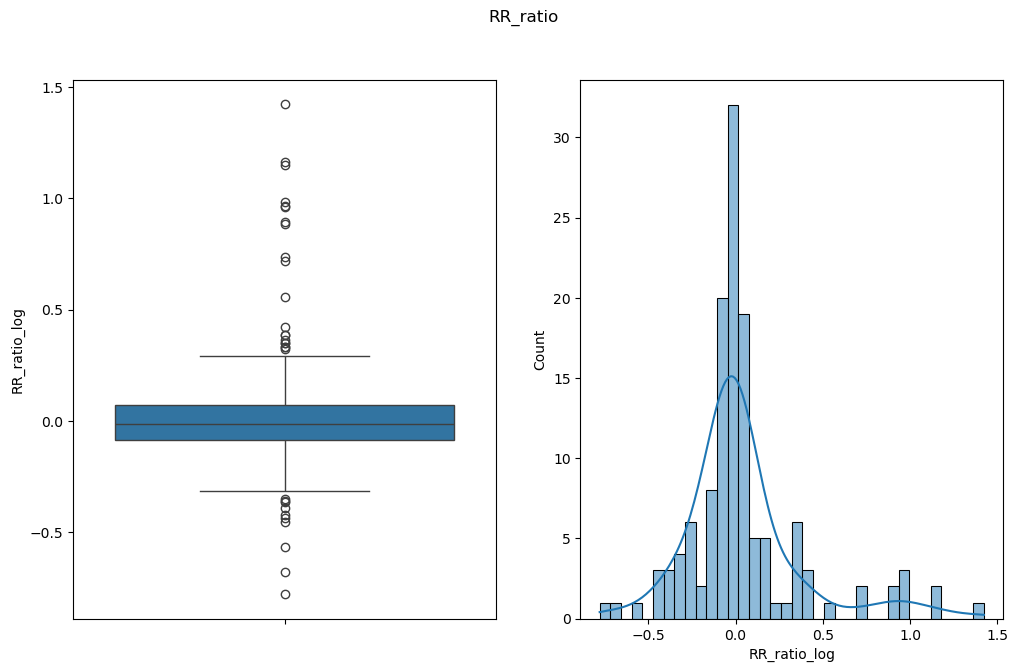

In [15]:
f, a = plt.subplots(1, 2, figsize=(12, 7))
sns.boxplot(errors['A_pre_ratio_log'], ax=a[0])
sns.histplot(errors['A_pre_ratio_log'], ax=a[1], kde=True)
f.suptitle('A_pre_ratio')
plt.show()

f, a = plt.subplots(1, 2, figsize=(12, 7))
sns.boxplot(errors['A_post_ratio_log'], ax=a[0])
sns.histplot(errors['A_post_ratio_log'], ax=a[1], kde=True)
f.suptitle('A_post_ratio')
plt.show()

f, a = plt.subplots(1, 2, figsize=(12, 7))
sns.boxplot(errors['W_pre_ratio_log'], ax=a[0])
sns.histplot(errors['W_pre_ratio_log'], ax=a[1], kde=True)
f.suptitle('W_pre_ratio')
plt.show()

f, a = plt.subplots(1, 2, figsize=(12, 7))
sns.boxplot(errors['W_post_ratio_log'], ax=a[0])
sns.histplot(errors['W_post_ratio_log'], ax=a[1], kde=True)
f.suptitle('W_post_ratio')
plt.show()

f, a = plt.subplots(1, 2, figsize=(12, 7))
sns.boxplot(errors['RR_ratio_log'], ax=a[0])
sns.histplot(errors['RR_ratio_log'], ax=a[1], kde=True)
f.suptitle('RR_ratio')
plt.show()

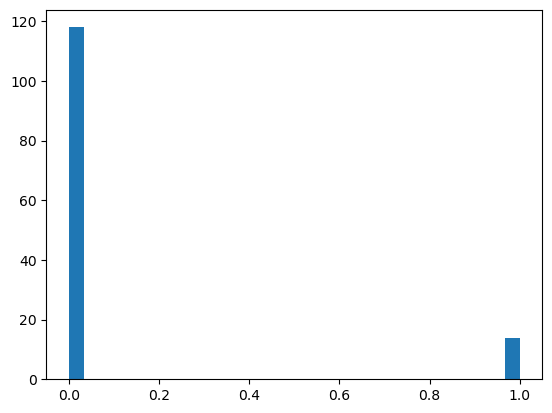

In [16]:
plt.hist(errors['Isolated'], bins=30)
plt.show()

In [17]:
errors.to_csv("Supervised_learning/Error_processed_sup.csv", index=False)

# Feature selection

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold

In [19]:
errors = pd.read_csv("Supervised_learning/Error_processed_sup.csv")
errors.keys()

Index(['id_subject', 'id_segment', 'id_error', 'idt', 't', 'id_BayeSlope',
       'signal', 'Amplitude', 'A_pre', 'A_pre_ratio', 'A_post', 'A_post_ratio',
       'Width', 'W_pre', 'W_pre_ratio', 'W_post', 'W_post_ratio', 'RR_pre',
       'RR_post', 'RR_ratio', 'consecutive_errors', 'Isolated',
       'error_class_label', 'A_pre_ratio_log', 'A_post_ratio_log',
       'W_pre_ratio_log', 'W_post_ratio_log', 'RR_ratio_log'],
      dtype='object')

### Multicolineality

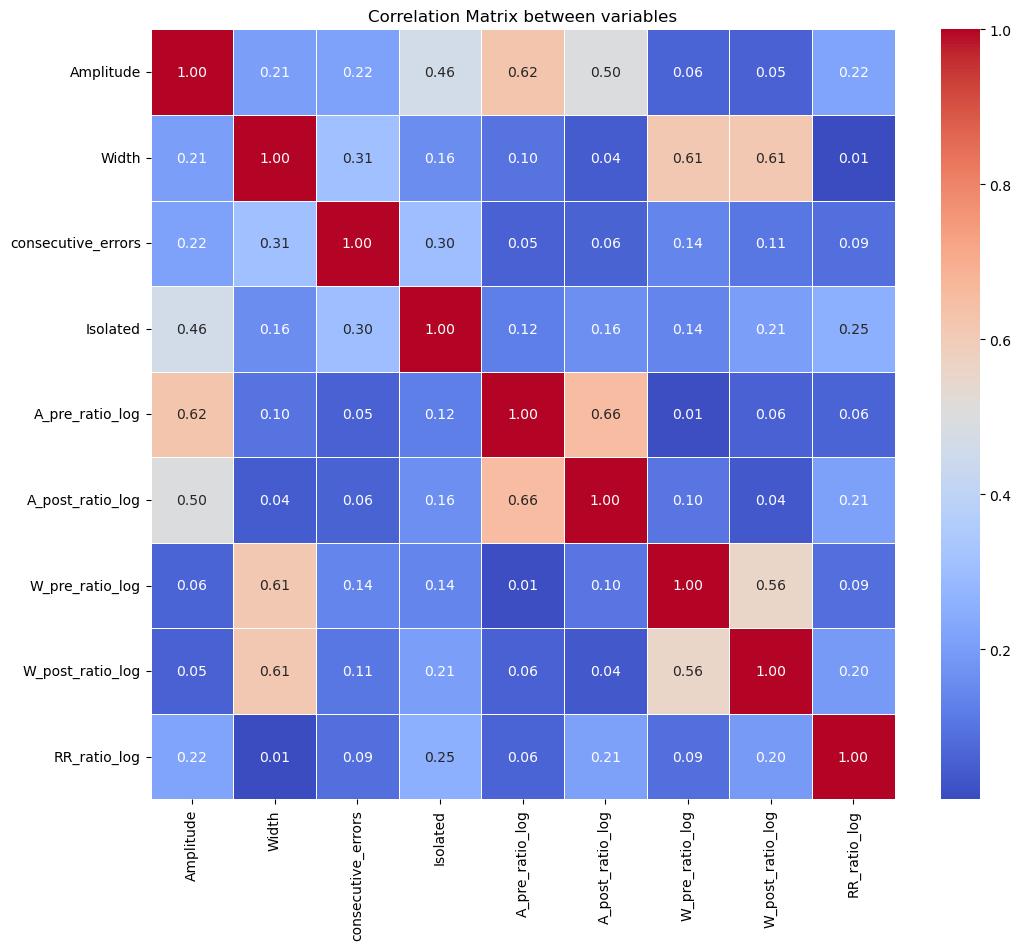

In [20]:
variables = errors[['Amplitude', 'Width', 'consecutive_errors', 'Isolated',
       #'A_pre', 'A_post', 'W_pre', 'W_post', 'RR_pre', 'RR_post',
       #'A_pre_ratio', 'A_post_ratio', 'W_pre_ratio', 'W_post_ratio', 'RR_ratio',
       'A_pre_ratio_log', 'A_post_ratio_log', 'W_pre_ratio_log', 'W_post_ratio_log', 'RR_ratio_log']]

correlations = variables.corr().abs()

plt.figure(figsize=(12, 10))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix between variables')
plt.show()

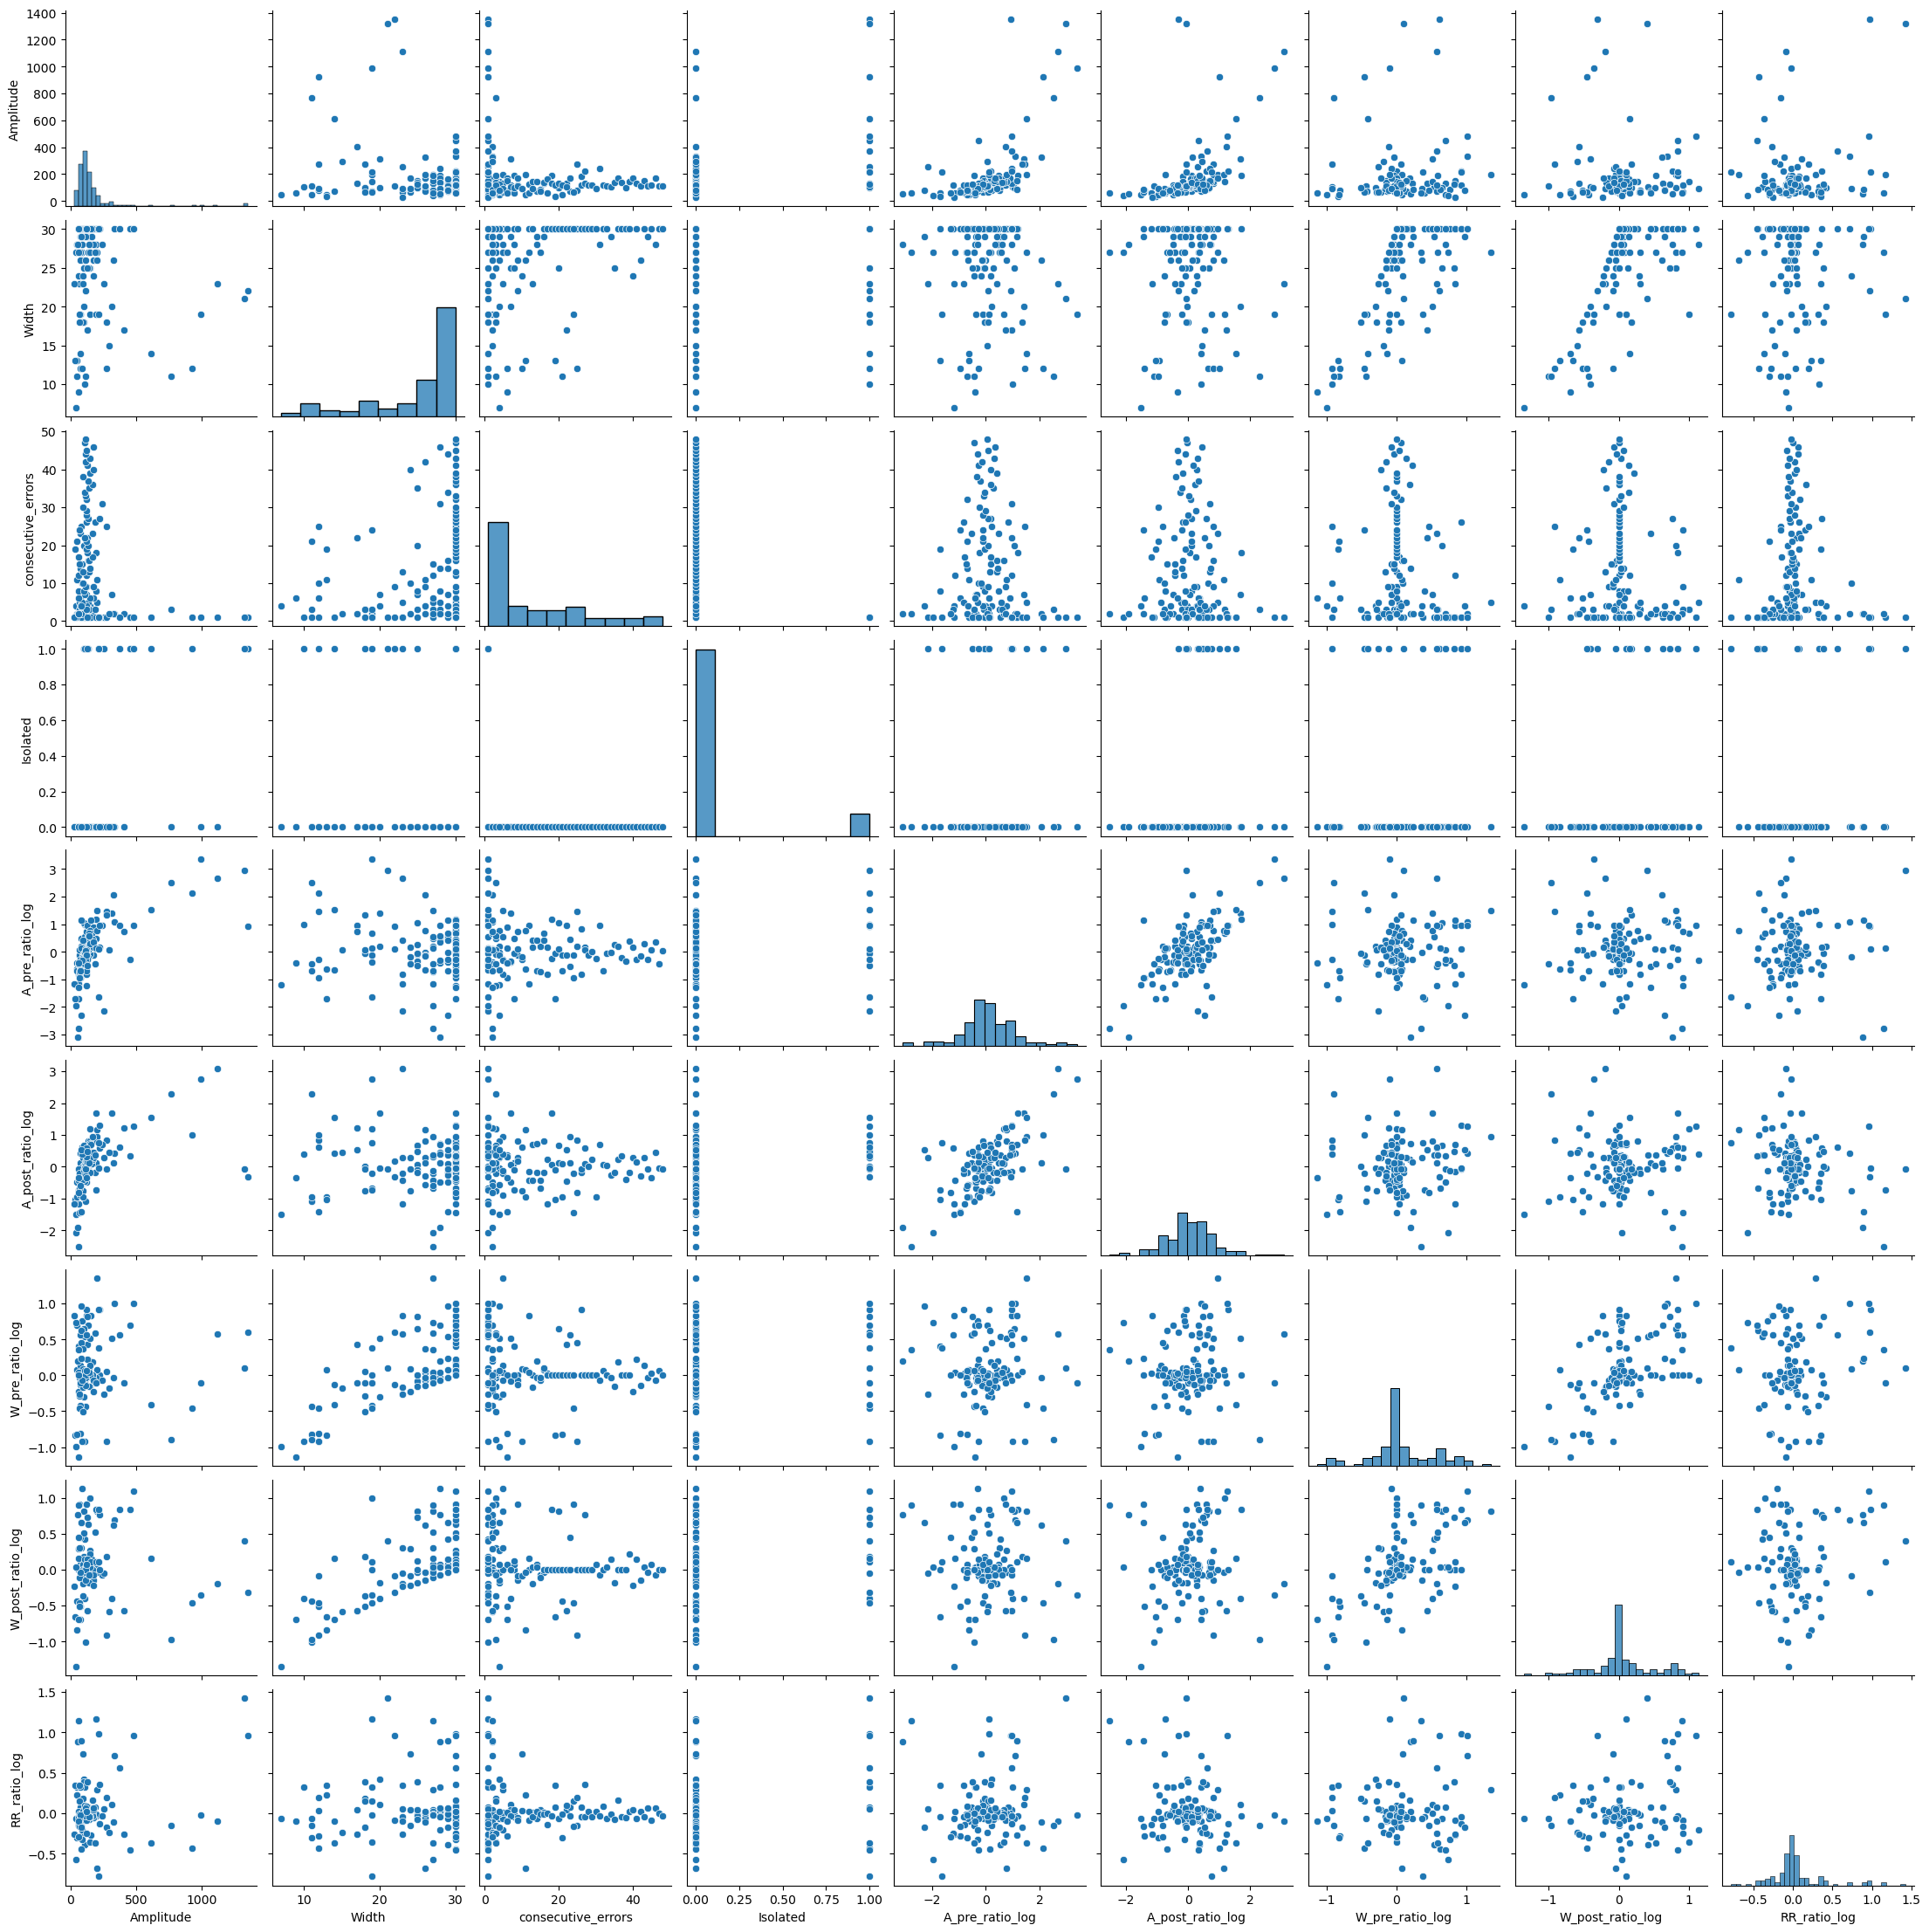

In [21]:
sns.pairplot(variables)

For now, I will use the following variables:
* Isolated
* consecutive_errors
* Amplitude
* Width
* A_pre_ratio
* A_post_ratio
* W_pre_ratio
* W_post_ratio
* RR_ratio

### Feature selection algorithm

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
 
def plot_feature_importance_ieee(df_grouped, features, label_column='Label'):
    # Set white background
    sns.set_style("white")
    plt.figure(figsize=(5.5, 5), dpi=600)
    
    # Prepare data
    X = df_grouped[features]
    y = df_grouped[label_column]
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 1. Mutual Information
    mi_scores = mutual_info_classif(X_scaled, y, random_state=42)
    mi_df = pd.DataFrame({'Feature': features, 'Importance': mi_scores, 'Method': 'MI'})
    
    # 2. Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_scaled, y)
    rf_df = pd.DataFrame({'Feature': features, 'Importance': rf.feature_importances_, 'Method': 'RF'})
    
    # 3. Permutation Importance
    perm_results = permutation_importance(rf, X_scaled, y, n_repeats=10, random_state=42)
    perm_df = pd.DataFrame({'Feature': features, 'Importance': perm_results.importances_mean, 'Method': 'PI'})
    
    # 4. Recursive Feature Elimination (RFE)
    rfe = RFE(estimator=RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=1)
    rfe.fit(X_scaled, y)
    rfe_ranks = rfe.ranking_
    rfe_df = pd.DataFrame({'Feature': features, 'Importance': 1 / rfe_ranks, 'Method': 'RFE'})
    
    # Combine and normalize
    importance_df = pd.concat([mi_df, rf_df, perm_df, rfe_df])
    importance_df["Importance"] /= importance_df.groupby("Method")["Importance"].transform("max")
    
    # Slight visual marker for zero-importance values
    importance_df["Importance_display"] = importance_df["Importance"].apply(lambda x: 0.004 if x == 0 else x)
    
    # Sort features by mean importance
    feature_order = importance_df.groupby("Feature")["Importance"].mean().sort_values(ascending=False).index
    importance_df["Feature"] = pd.Categorical(importance_df["Feature"], categories=feature_order, ordered=True)
    importance_df = importance_df.sort_values("Feature")
    
    # Fonts and styles
    #plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['font.size'] = 7
    
    # Grayscale color palette
    grayscale_palette = {
        'MI': '#333333',
        'RF': '#666666',
        'PI': '#999999',
        'RFE': '#CCCCCC'
    }
    
    # Plot bars
    g = sns.barplot(
        x='Importance_display',
        y='Feature',
        hue='Method',
        data=importance_df,
        dodge=True,
        palette=grayscale_palette,
        edgecolor='black',
        alpha=1.0
    )
    
    # Ensure axes background is white
    plt.gca().set_facecolor("white")
    
    # Uniform styling for all bars
    for container, method in zip(g.containers, ['MI', 'RF', 'PI', 'RFE']):
        for bar in container:
            bar.set_facecolor(grayscale_palette[method])
            bar.set_edgecolor('black')
            bar.set_linewidth(0.6)
            bar.set_alpha(1.0)
    
    # Label and grid
    plt.title('')
    plt.ylabel('')
    plt.xlabel('Normalized Importance Score', fontsize=7)
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    plt.legend(title='Method', loc='lower right', fontsize=6, title_fontsize=7)
    
    plt.tight_layout()
    plt.savefig('ieee_feature_importance_white_bg.pdf', bbox_inches='tight', dpi=600)
    plt.savefig('ieee_feature_importance_white_bg.png', bbox_inches='tight', dpi=600)
    plt.show()
    
    return importance_df

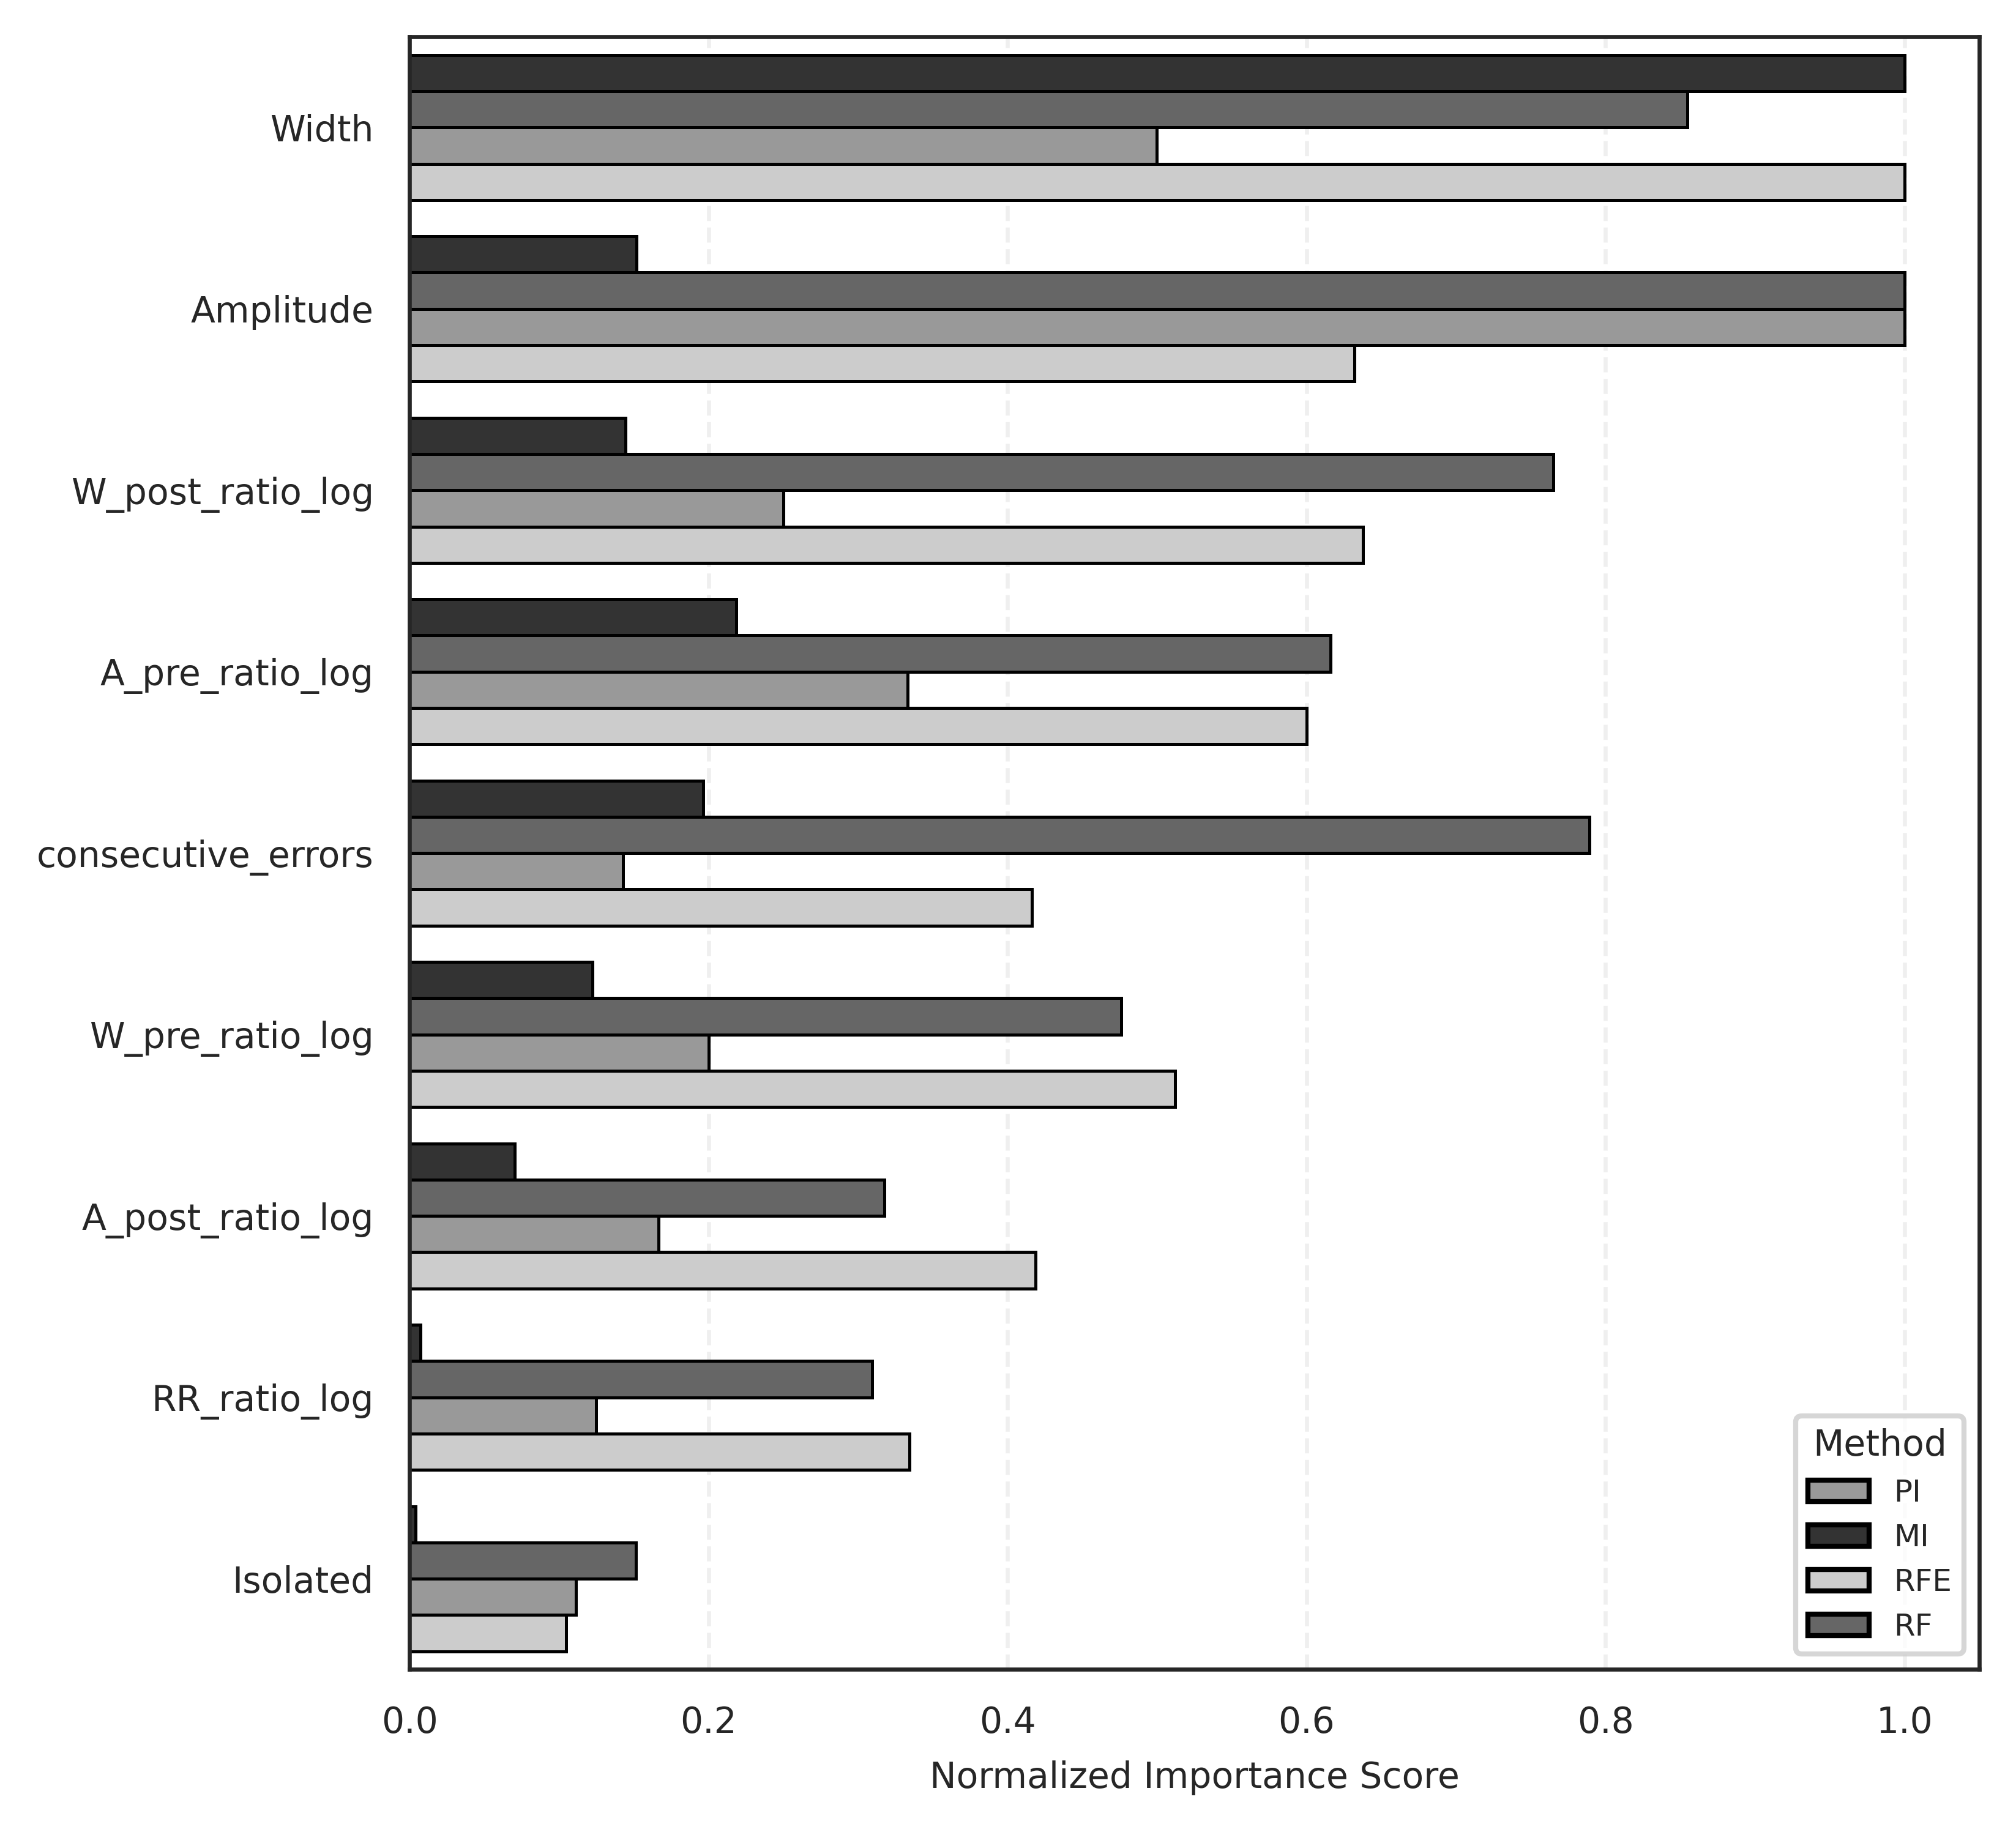

In [23]:
features = [
    'Isolated', 'consecutive_errors', 'Amplitude', 'Width', 'A_pre_ratio_log', 'A_post_ratio_log', 'W_pre_ratio_log', 'W_post_ratio_log', 'RR_ratio_log'
]
importance_results = plot_feature_importance_ieee(errors, features, label_column='error_class_label')

That ranking is:
1. Width
2. Amplitude
3. W_post_ratio
4. A_pre_ratio
5. consecutive_errors
6. W_pre_ratio
7. A_post_ratio
8. RR_ratio
9. Isolated

* 'Isolated' has a really bad puntuation and probably does not give information 'consecutive_errors' does not give, so I will not use it to train
* I will try using all the other 8 features or the first 5 features

# Models

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut, ParameterGrid
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler

In [25]:
errors = pd.read_csv("Supervised_learning/Error_processed_sup.csv")
errors.keys()

Index(['id_subject', 'id_segment', 'id_error', 'idt', 't', 'id_BayeSlope',
       'signal', 'Amplitude', 'A_pre', 'A_pre_ratio', 'A_post', 'A_post_ratio',
       'Width', 'W_pre', 'W_pre_ratio', 'W_post', 'W_post_ratio', 'RR_pre',
       'RR_post', 'RR_ratio', 'consecutive_errors', 'Isolated',
       'error_class_label', 'A_pre_ratio_log', 'A_post_ratio_log',
       'W_pre_ratio_log', 'W_post_ratio_log', 'RR_ratio_log'],
      dtype='object')

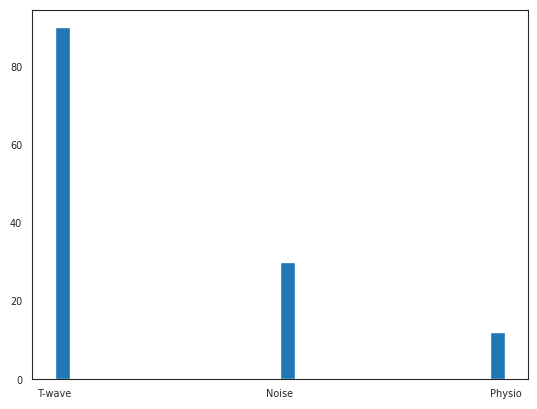

In [26]:
y = errors['error_class_label']
plt.hist(y, bins=30)
plt.show()

In [27]:
total = errors["error_class_label"].value_counts()
print(total)

error_class_label
T-wave    90
Noise     30
Physio    12
Name: count, dtype: int64


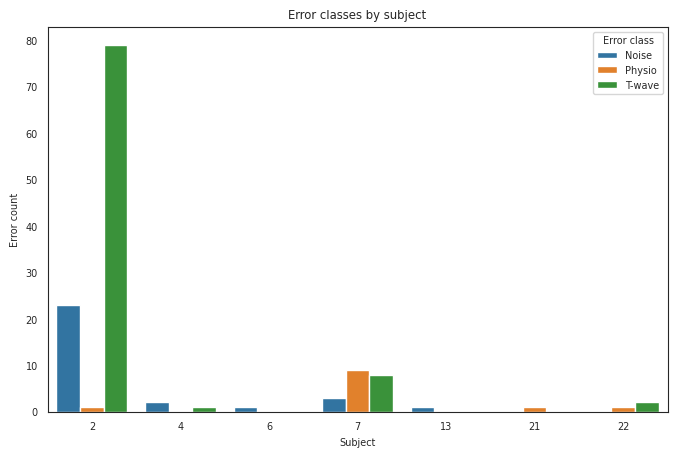

In [28]:
# Error classes by subject
counts = errors.groupby(["id_subject", "error_class_label"]).size().reset_index(name="count")
plt.figure(figsize=(8,5))
sns.barplot(data=counts, x="id_subject", y="count", hue="error_class_label")
plt.title("Error classes by subject")
plt.xlabel("Subject")
plt.ylabel("Error count")
plt.legend(title="Error class")
plt.show()

In [29]:
by_subject = errors.groupby(["id_subject", "error_class_label"]).size().unstack(fill_value=0)
print(by_subject)

error_class_label  Noise  Physio  T-wave
id_subject                              
2                     23       1      79
4                      2       0       1
6                      1       0       0
7                      3       9       8
13                     1       0       0
21                     0       1       0
22                     0       1       2


### Cross-Validation

In [30]:
def undersampling_sub2(train_set, n_twave, n_noise):
    # T-wave
    sub2_t = train_set[(train_set['id_subject']==2) & (train_set['error_class_label'] == "T-wave")]
    sub2_t_under = sub2_t.sample(n=n_twave, random_state=35)
    # Noise
    sub2_n = train_set[(train_set['id_subject']==2) & (train_set['error_class_label'] == "Noise")]
    sub2_n_under = sub2_t.sample(n=n_noise, random_state=35)
    # Physio
    sub2_p = train_set[(train_set['id_subject']==2) & (train_set['error_class_label'] == "Physio")]
    return pd.concat([train_set[train_set['id_subject']!=2], sub2_t_under, sub2_n_under, sub2_p])

In [31]:
variables = [
    ['consecutive_errors', 'Amplitude', 'Width', 'A_pre_ratio_log', 'A_post_ratio_log', 'W_pre_ratio_log', 'W_post_ratio_log', 'RR_ratio_log'],
    ['consecutive_errors', 'Amplitude', 'Width', 'A_pre_ratio_log', 'W_post_ratio_log'],
    ['consecutive_errors', 'Amplitude', 'Width', 'RR_ratio_log'],
    ['Amplitude', 'Width', 'W_post_ratio_log',]
]

In [32]:
# Models
M = ['knn', 'svm', 'rf']
# Parametres
knn_params = {
    'n_neighbors': [1, 2, 3],
    'p': [1, 2]
}
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'sigmoid', 'linear', 'poly']
}
rf_params = {
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf': [2, 5]
}
P = [knn_params, svm_params, rf_params]

In [33]:
logo = LeaveOneGroupOut()

results = pd.DataFrame(columns=['Variables', 'model', 'params', 'f1_macro', 'f1_weighted', 'f1_noise', 'f1_physio', 'f1_twave'])

for i in range(4):
    var = variables[i]

    for j in range(3):
        model_name = M[j]
        params_grid = P[j]
        for params in ParameterGrid(params_grid):
            params_str = str(params)
            f1_macro_folds = []
            f1_n_folds = []
            f1_p_folds = []
            f1_t_folds = []
            f1_weighted_folds = []

            for train_idx, test_idx in logo.split(errors[var], errors['error_class_label'], errors['id_subject']):

                # train and test sets
                errors_train, errors_test = errors.iloc[train_idx], errors.iloc[test_idx]
                g_test = errors['id_subject'].iloc[test_idx].iloc[0]
                if g_test!=2:
                    errors_train = undersampling_sub2(errors_train, 10, 10)
                X_train, y_train = errors_train[var], errors_train['error_class_label']
                X_test, y_test = errors_test[var], errors_test['error_class_label']

                # Feature scaling
                scaler = StandardScaler()
                X_train_scl = scaler.fit_transform(X_train)
                X_test_scl = scaler.transform(X_test)
                
                # Model training and evaluation
                if j==0:
                    model = KNeighborsClassifier(**params)
                elif j==1:
                    model = SVC(**params, class_weight='balanced', degree=2, random_state=35)
                else:
                    model = RandomForestClassifier(**params, random_state=35)
                model.fit(X_train_scl, y_train)
                y_pred = model.predict(X_test_scl)
                f1_macro_folds.append(f1_score(y_test, y_pred, average='macro'))
                if 'Noise' in y_test.values:
                    f1_n_folds.append(f1_score(y_test, y_pred, labels=['Noise'], average=None)[0])
                if 'Physio' in y_test.values:
                    f1_p_folds.append(f1_score(y_test, y_pred, labels=['Physio'], average=None)[0])
                if 'T-wave' in y_test.values:
                    f1_t_folds.append(f1_score(y_test, y_pred, labels=['T-wave'], average=None)[0])
                f1_weighted_folds.append(f1_score(y_test, y_pred, average='weighted'))
                
            f1_macro_mean = np.mean(f1_macro_folds)
            f1_n_mean = np.mean(f1_n_folds)
            f1_p_mean = np.mean(f1_p_folds)
            f1_t_mean = np.mean(f1_t_folds)
            f1_weighted_mean = np.mean(f1_weighted_folds)

            r = pd.DataFrame({'Variables': [i], 'model': [model_name], 'params': [params_str],
                              'f1_macro': [f1_macro_mean], 'f1_weighted': [f1_weighted_mean],
                              'f1_noise': [f1_n_mean], 'f1_physio': [f1_p_mean], 'f1_twave':[f1_t_mean]})
            results = pd.concat([results, r], axis=0, ignore_index=True)

results.sort_values(by='f1_macro', ascending=False, inplace=True)
results

/tmp/ipykernel_3029263/3468383247.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, r], axis=0, ignore_index=True)


,Variables,model,params,f1_macro,f1_weighted,f1_noise,f1_physio,f1_twave
55,2,svm,"{'C': 1, 'kernel': 'sigmoid'}",0.616649,0.711411,0.525806,0.333333,0.584314
59,2,svm,"{'C': 10, 'kernel': 'sigmoid'}",0.568645,0.646682,0.527586,0.343750,0.419653
56,2,svm,"{'C': 1, 'kernel': 'linear'}",0.506976,0.605117,0.419140,0.333333,0.604367
37,1,svm,"{'C': 10, 'kernel': 'sigmoid'}",0.491407,0.611447,0.507586,0.426471,0.418935
60,2,svm,"{'C': 10, 'kernel': 'linear'}",0.487870,0.579963,0.364103,0.333333,0.610357
...,...,...,...,...,...,...,...,...
72,3,svm,"{'C': 0.1, 'kernel': 'rbf'}",0.224132,0.308417,0.133333,0.155172,0.588186
68,3,knn,"{'n_neighbors': 2, 'p': 1}",0.216940,0.230570,0.076364,0.300000,0.243478
75,3,svm,"{'C': 0.1, 'kernel': 'poly'}",0.210695,0.282631,0.071429,0.125000,0.729362
31,1,svm,"{'C': 0.1, 'kernel': 'poly'}",0.188706,0.252937,0.054545,0.090909,0.669115


In [34]:
results.to_csv("Supervised_learning/results_sup.csv", index=False, encoding="utf-8", sep=";")

### Confusion matrix

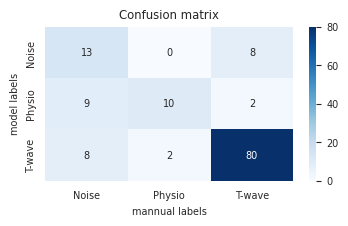

In [35]:
# model
params = {'C': 1, 'kernel': 'sigmoid'}
model = SVC(**params, class_weight='balanced', degree=2, random_state=35)

# training data
errors_unders = undersampling_sub2(errors, 10, 10)
X_unders, y_unders = errors_unders[variables[2]], errors_unders['error_class_label']
scaler = StandardScaler()
X_unders_scl = scaler.fit_transform(X_unders)
# matrix data
X, y = errors[variables[2]], errors['error_class_label']
X_scl = scaler.transform(X)

# training
model.fit(X_unders_scl, y_unders)
y_pred = model.predict(X_scl)

# Confusion matrix
matrix = pd.crosstab(y_pred, y)
plt.figure(figsize=(4, 2))
sns.heatmap(matrix, annot=True, cmap="Blues")
plt.title("Confusion matrix")
plt.xlabel('mannual labels')
plt.ylabel('model labels')
plt.show()

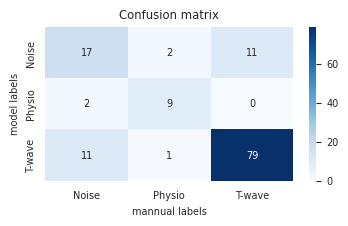

In [36]:
# model
params = {'C': 10, 'kernel': 'sigmoid'}
model = SVC(**params, class_weight='balanced', degree=2, random_state=35)

# training data
errors_unders = undersampling_sub2(errors, 10, 10)
X_unders, y_unders = errors_unders[variables[2]], errors_unders['error_class_label']
scaler = StandardScaler()
X_unders_scl = scaler.fit_transform(X_unders)
# matrix data
X, y = errors[variables[2]], errors['error_class_label']
X_scl = scaler.transform(X)

# training
model.fit(X_unders_scl, y_unders)
y_pred = model.predict(X_scl)

# Confusion matrix
matrix = pd.crosstab(y_pred, y)
plt.figure(figsize=(4, 2))
sns.heatmap(matrix, annot=True, cmap="Blues")
plt.title("Confusion matrix")
plt.xlabel('mannual labels')
plt.ylabel('model labels')
plt.show()

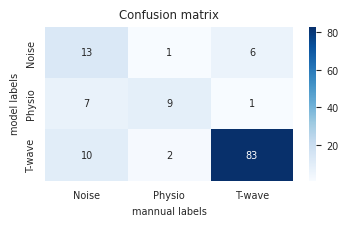

In [37]:
# model
params = {'C': 1, 'kernel': 'linear'}
model = SVC(**params, class_weight='balanced', degree=2, random_state=35)

# training data
errors_unders = undersampling_sub2(errors, 10, 10)
X_unders, y_unders = errors_unders[variables[2]], errors_unders['error_class_label']
scaler = StandardScaler()
X_unders_scl = scaler.fit_transform(X_unders)
# matrix data
X, y = errors[variables[2]], errors['error_class_label']
X_scl = scaler.transform(X)

# training
model.fit(X_unders_scl, y_unders)
y_pred = model.predict(X_scl)

# Confusion matrix
matrix = pd.crosstab(y_pred, y)
plt.figure(figsize=(4, 2))
sns.heatmap(matrix, annot=True, cmap="Blues")
plt.title("Confusion matrix")
plt.xlabel('mannual labels')
plt.ylabel('model labels')
plt.show()